In [5]:
import numpy as np
import torch
import cv2
import json
import matplotlib.pyplot as plt
from pathlib import Path
import sys
if "../model" not in sys.path:
    sys.path.insert(0, "../model")
    
from typing import Any

In [12]:
coco_root = Path("/home/dherrera/data/coco")
training_data_root = Path("/home/dherrera/data/elephants/training_data")

In [ ]:
coco_json: dict[str, Any] = json.load(
    (coco_root / "annotations/instances_train2017.json").open()
)
type(coco_json)

dict

In [181]:
display(coco_json.keys())
display(coco_json["images"][0])
display(coco_json["annotations"][0])
coco_categories = coco_json["categories"]
display(coco_categories)

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

{'license': 3,
 'file_name': '000000391895.jpg',
 'coco_url': 'http://images.cocodataset.org/train2017/000000391895.jpg',
 'height': 360,
 'width': 640,
 'date_captured': '2013-11-14 11:18:45',
 'flickr_url': 'http://farm9.staticflickr.com/8186/8119368305_4e622c8349_z.jpg',
 'id': 391895}

{'segmentation': [[239.97,
   260.24,
   222.04,
   270.49,
   199.84,
   253.41,
   213.5,
   227.79,
   259.62,
   200.46,
   274.13,
   202.17,
   277.55,
   210.71,
   249.37,
   253.41,
   237.41,
   264.51,
   242.54,
   261.95,
   228.87,
   271.34]],
 'area': 2765.1486500000005,
 'iscrowd': 0,
 'image_id': 558840,
 'bbox': [199.84, 200.46, 77.71, 70.88],
 'category_id': 58,
 'id': 156}

[{'supercategory': 'person', 'id': 1, 'name': 'person'},
 {'supercategory': 'vehicle', 'id': 2, 'name': 'bicycle'},
 {'supercategory': 'vehicle', 'id': 3, 'name': 'car'},
 {'supercategory': 'vehicle', 'id': 4, 'name': 'motorcycle'},
 {'supercategory': 'vehicle', 'id': 5, 'name': 'airplane'},
 {'supercategory': 'vehicle', 'id': 6, 'name': 'bus'},
 {'supercategory': 'vehicle', 'id': 7, 'name': 'train'},
 {'supercategory': 'vehicle', 'id': 8, 'name': 'truck'},
 {'supercategory': 'vehicle', 'id': 9, 'name': 'boat'},
 {'supercategory': 'outdoor', 'id': 10, 'name': 'traffic light'},
 {'supercategory': 'outdoor', 'id': 11, 'name': 'fire hydrant'},
 {'supercategory': 'outdoor', 'id': 13, 'name': 'stop sign'},
 {'supercategory': 'outdoor', 'id': 14, 'name': 'parking meter'},
 {'supercategory': 'outdoor', 'id': 15, 'name': 'bench'},
 {'supercategory': 'animal', 'id': 16, 'name': 'bird'},
 {'supercategory': 'animal', 'id': 17, 'name': 'cat'},
 {'supercategory': 'animal', 'id': 18, 'name': 'dog'},

In [6]:

from coco_utils import get_coco
ds = get_coco(
    root="/home/dherrera/data/coco",
    image_set="train",
    transforms=None,
    mode="instances",
    use_v2=False,
    with_masks=True,
)


loading annotations into memory...
Done (t=5.84s)
creating index...
index created!


In [124]:
from coco_utils import ConvertCocoPolysToMask,CocoDetection,T

t = [ConvertCocoPolysToMask()]
transforms = T.Compose(t)
ds_ele = CocoDetection("/home/dherrera/data/elephants/training_data", "/home/dherrera/data/elephants/training_data/annotations.json", transforms=transforms)



loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


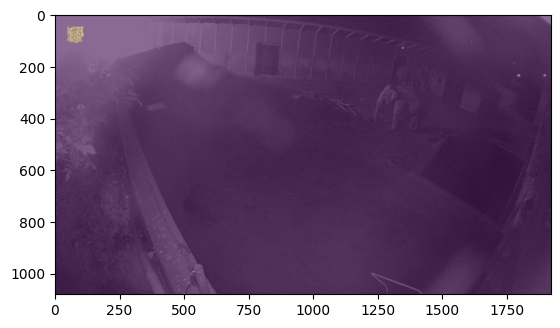

In [126]:
img,target = ds_ele[0]
plt.imshow(img)
plt.imshow(target["masks"][0],alpha=0.5)

In [7]:
ds[0][1].keys()

dict_keys(['boxes', 'labels', 'masks', 'image_id', 'area', 'iscrowd'])

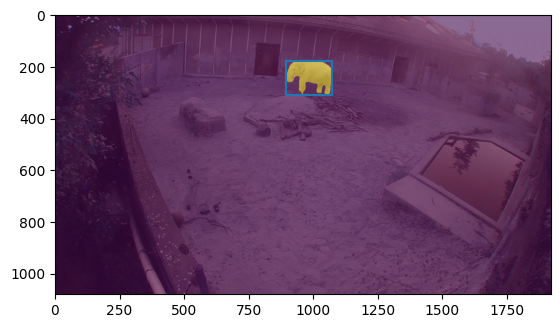

In [97]:
image_file = training_data_root/"Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_img.jpg"
segmentation_file = training_data_root/"Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00000000_seg.png"

image = cv2.imread(image_file)
segmentation = cv2.imread(segmentation_file,flags=cv2.IMREAD_GRAYSCALE)
ids = list(set(np.unique( segmentation)) - {0})
mask = segmentation==ids[0]

def bbox_from_mask(mask)->tuple[int,int,int,int]:
    mask_rows = np.any(mask,    axis=1)    
    mask_cols = np.any(mask,    axis=0)

    def line_start_size(values):
        start = values.argmax()-1
        end = values.shape[0] - np.flip(values).argmax()-1
        return (int(start),int( end-start))

    start_x, size_x = line_start_size(mask_cols)
    start_y, size_y = line_start_size(mask_rows)
    return (start_x,start_y,size_x,size_y)

bbox = bbox_from_mask(mask)
plt.imshow(image)
plt.imshow(mask,alpha=0.5)

def plot_bbox(ax, bbox):
    x0 = bbox[0]
    x1 = bbox[0]+bbox[2]
    y0 = bbox[1]
    y1 = bbox[1]+bbox[3]
    ax.plot([x0,x0, x1,x1,x0],[y0,y1,y1,y0,y0],"-")
plot_bbox(plt.gca(),bbox)

In [182]:
class IDGenerator:
    def __init__(self):
        self.next_id = 1
    def create(self)->int:
        id = self.next_id
        self.next_id += 1
        return id

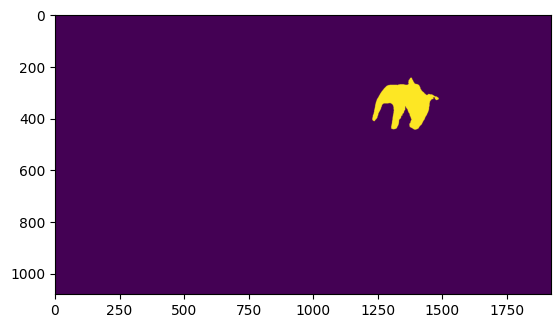

In [183]:
ELEPHANT_CATEGORY_ID = 22  # Same as in COCO


def create_elephant_annotation():
    return {
        "info": {
            "description": "Zoo Zurich Elephants 2025 Dataset",
            "url": "n/a",
            "version": "0.1",
            "year": 2025,
            "contributor": "Zoo Zurich",
            "date_created": "2025/02/01",
        },
        "licenses": [{"url": "non-public", "id": 1, "name": "Non-public"}],
        "categories": coco_categories,
        "images":[],
        "annotations": [],
    }


def make_image(id: int, name: str, height: int, width: int, date_captured: str):
    return {
        "license": 1,
        "file_name": name,
        "height": height,
        "width": width,
        "date_capture": date_captured,
        "id": id,
    }


import pycocotools.mask as coco_mask

def binary_mask_to_rle_np(binary_mask):
    rle = {"counts": [], "size": list(binary_mask.shape)}

    flattened_mask = binary_mask.ravel(order="F")
    diff_arr = np.diff(flattened_mask)
    nonzero_indices = np.where(diff_arr != 0)[0] + 1
    lengths = np.diff(np.concatenate(([0], nonzero_indices, [len(flattened_mask)])))

    # note that the odd counts are always the numbers of zeros
    if flattened_mask[0] == 1:
        lengths = np.concatenate(([0], lengths))

    rle["counts"] = lengths.tolist()

    return rle

def annotations_from_segmentation(id: IDGenerator, segmentation_file: Path, image_id: int):
    segmentation: np.ndarray = cv2.imread(segmentation_file, flags=cv2.IMREAD_GRAYSCALE)
    instance_ids = list(set(np.unique(segmentation)) - {0})
    annotations = []
    for instance_id in instance_ids:
        mask = segmentation == instance_id
        area = int(np.sum(mask))
        bbox = bbox_from_mask(mask)

        h,w = mask.shape
        mask_rle = binary_mask_to_rle_np(mask)
        # mask = mask.transpose().reshape(h,w)
        # mask = np.asfortranarray(mask)

        # mask_crle = coco_mask.encode(coco_mask.frPyObjects(mask_rle,h,w))
        # mask_crle["counts"]=list(mask_rle["counts"])
        # mask_compressed = coco_mask.frPyObjects(mask_rle, mask_rle.get('size')[0], mask_rle.get('size')[1])
        # mask_compressed =mask_rle

        annotation = {
            "segmentation": [mask_rle],
            "area": area,
            "iscrowd": 0,
            "image_id": image_id,
            "bbox": bbox,
            "category_id": ELEPHANT_CATEGORY_ID,
            "id": id.create(),
        }
        annotations.append(annotation)
    return annotations

a=(annotations_from_segmentation(IDGenerator(), segmentation_file,0))

from coco_utils import convert_coco_poly_to_mask
image = cv2.imread(image_file)
plt.imshow(image)
segmentations = a[0]["segmentation"]
mask = convert_coco_poly_to_mask(segmentations, image.shape[0],image.shape[1])[0]
plt.imshow(mask,alpha=1)

In [83]:
a[0]["segmentation"]["counts"][0]

95

In [184]:
from glob import glob

root = Path("/home/dherrera/data/elephants/training_data")
files = glob("**/*_img.jpg",root_dir=root, recursive=True)
display(files)

['Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00084011_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00062467_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00057286_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00063582_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00104536_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00053674_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00069692_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00057396_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00083731_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00062297_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00069962_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00063092_img.jpg',
 'Kamera 01/ELP-Kamera-01-20240907-185521-1725728121288-7_00019773_img.jpg',

In [186]:
from tqdm import tqdm

elephant_annotations = create_elephant_annotation()
gen_image_id = IDGenerator()
gen_annotation_id = IDGenerator()

for file in tqdm(files):
    image_id = gen_image_id.create()
    segmentation_file = root / file.replace("_img.jpg", "_seg.png")
    image_json=    make_image(
            id=image_id, name=file, height=1080, width=1920, date_captured="2025-02-01"
        )
    

    annotations_json = annotations_from_segmentation(
        id=gen_annotation_id, segmentation_file=segmentation_file, image_id=image_id
    )

    elephant_annotations["images"].append(image_json)
    elephant_annotations["annotations"].extend(annotations_json)

annotation_count=len(elephant_annotations["annotations"])
print(f"{annotation_count=}")
with (root/"annotations.json").open("w") as f:
    json.dump(elephant_annotations,f,indent=1)


100%|██████████| 272/272 [00:04<00:00, 67.95it/s]


annotation_count=272


In [103]:
elephant_annotations["annotations"][0]["segmentation"]

[[95,
  102,
  98,
  88,
  49,
  63,
  84,
  81,
  49,
  56,
  72,
  56,
  75,
  50,
  74,
  54,
  73,
  55,
  77,
  51,
  74,
  54,
  76,
  52,
  76,
  52,
  74,
  54,
  76,
  50,
  48,
  48,
  78,
  50,
  79,
  48,
  48,
  48,
  49,
  48,
  48,
  77,
  51,
  48,
  48,
  79,
  49,
  79,
  49,
  48,
  48,
  77,
  52,
  78,
  49,
  79,
  49,
  79,
  50,
  48,
  79,
  48,
  48,
  49,
  48,
  77,
  50,
  49,
  48,
  79,
  48,
  49,
  48,
  75,
  54,
  79,
  48,
  49,
  78,
  49,
  48,
  48,
  79,
  49,
  79,
  49,
  48,
  49,
  79,
  49,
  78,
  50,
  79,
  50,
  78,
  49,
  79,
  49,
  79,
  49,
  79,
  49,
  79,
  50,
  78,
  49,
  79,
  49,
  79,
  49,
  79,
  49,
  79,
  49,
  48,
  48,
  79,
  49,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  79,
  50,
  79,
  48,
  48,
  79,
  49,
  48,
  48,
  48,
  48,
  48,
  48,
  48,
  94,
  83,
  79,
  104,
  77,
  100,
  105,
  48,
  88,
  50,
  86,
  86,
  79,
  111,
  77,
  106,
  105,
  48,
  80,
  50,
  81,
  86,
  79,
  8